## House Prices - Advanced Regression Techniques

#### The goal of the notebook is to predict sale price for each Id in the test set.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data Exploration

In [3]:
housing_raw_train_data = pd.read_csv('train.csv')
housing_train_data = housing_raw_train_data.copy()
housing_train_data.name = 'housing_train_data'

housing_raw_test_data = pd.read_csv('test.csv')
housing_test_data = housing_raw_test_data.copy()

In [4]:
housing_train_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
housing_train_data.drop('Id', axis=1, inplace=True)
housing_test_data.drop('Id', axis=1, inplace=True)

#### Define Numeric/Object columns

In [6]:
list(set(housing_train_data.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('O')]

In [7]:
numerics = ['int64', 'float64']
objects = ['O']
numeric_df = housing_train_data.select_dtypes(include=numerics)
object_df = housing_train_data.select_dtypes(include=objects)
print('There are', len(numeric_df.columns), 'numeric columns and', len(object_df.columns), 'object columns in the', housing_train_data.name, 'dataset')

There are 37 numeric columns and 43 object columns in the housing_train_data dataset


In [8]:
len(housing_train_data.columns), len(numeric_df.columns), len(object_df.columns)

(80, 37, 43)

#### Missing Data Analysis

In [9]:
corr_matrix = numeric_df.corr()
corr_matrix['SalePrice'][:-1].sort_values(ascending=False) # -1 to avoid showing SalePrice = 1 correlation

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

### Price Distribution

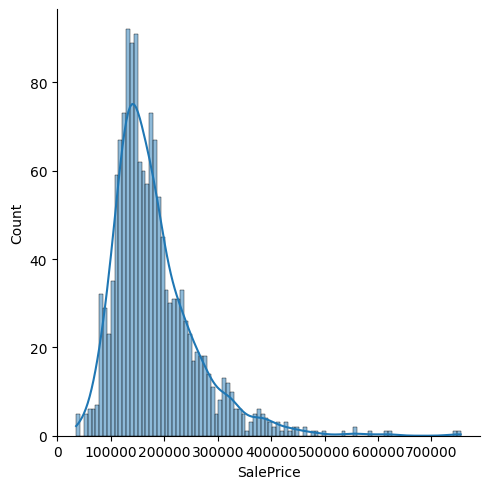

In [10]:
from scipy.stats import norm, stats

sns.displot(housing_train_data['SalePrice'], bins=100, kde=True)
plt.show()

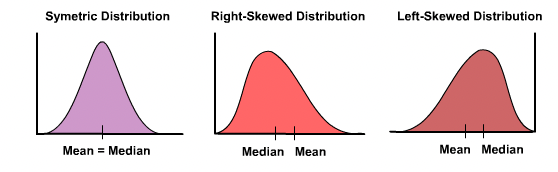

In [11]:
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 

In [12]:
scale_price_profile = pd.DataFrame()
scale_price_profile['SalePrice Raw'] = housing_train_data['SalePrice']
scale_price_profile['SalePrice Log'] = np.log(housing_train_data['SalePrice'])
scale_price_profile['SalePrice Square Root'] = np.sqrt(housing_train_data['SalePrice'])
scale_price_profile['SalePrice Cube Root'] = np.cbrt(housing_train_data['SalePrice'])

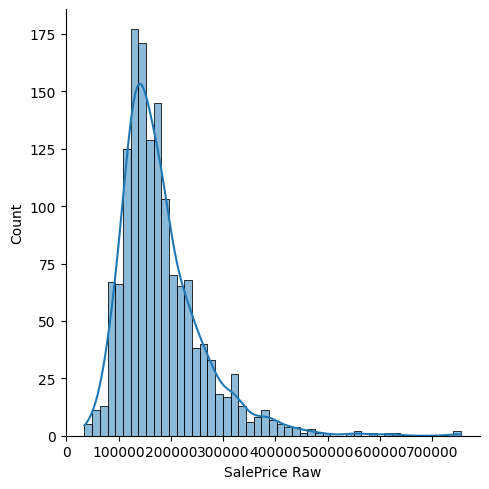

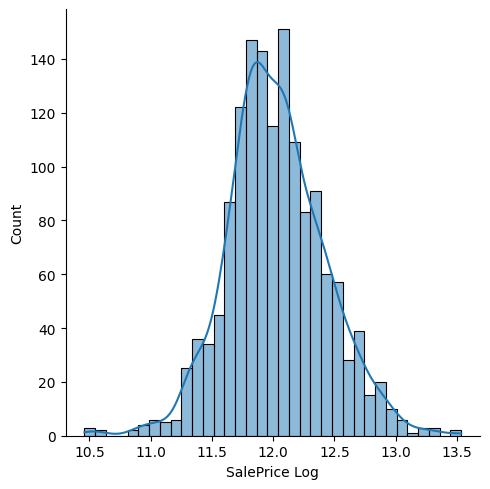

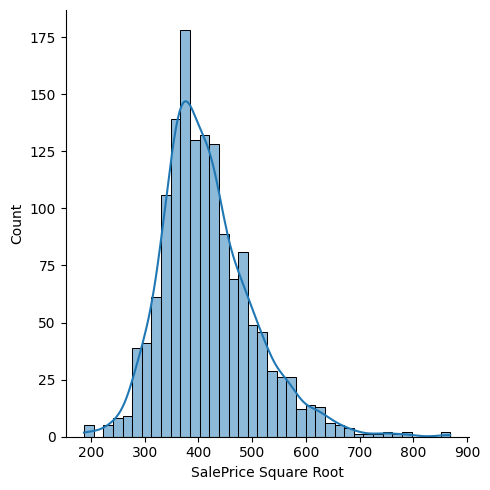

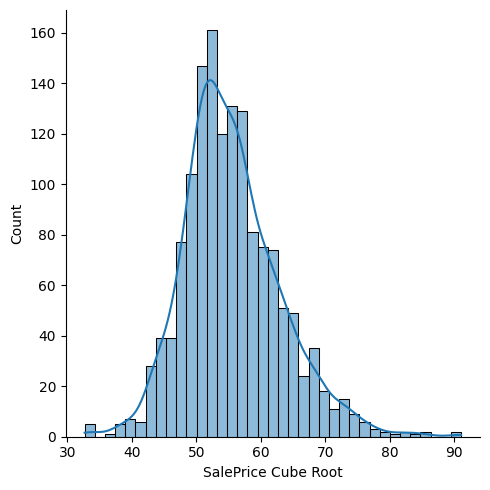

In [13]:
for column in scale_price_profile.columns:
    sns.displot(scale_price_profile[column], kde=True)

The lot transformation is the one that resembles the most to a Gaussian distribution 

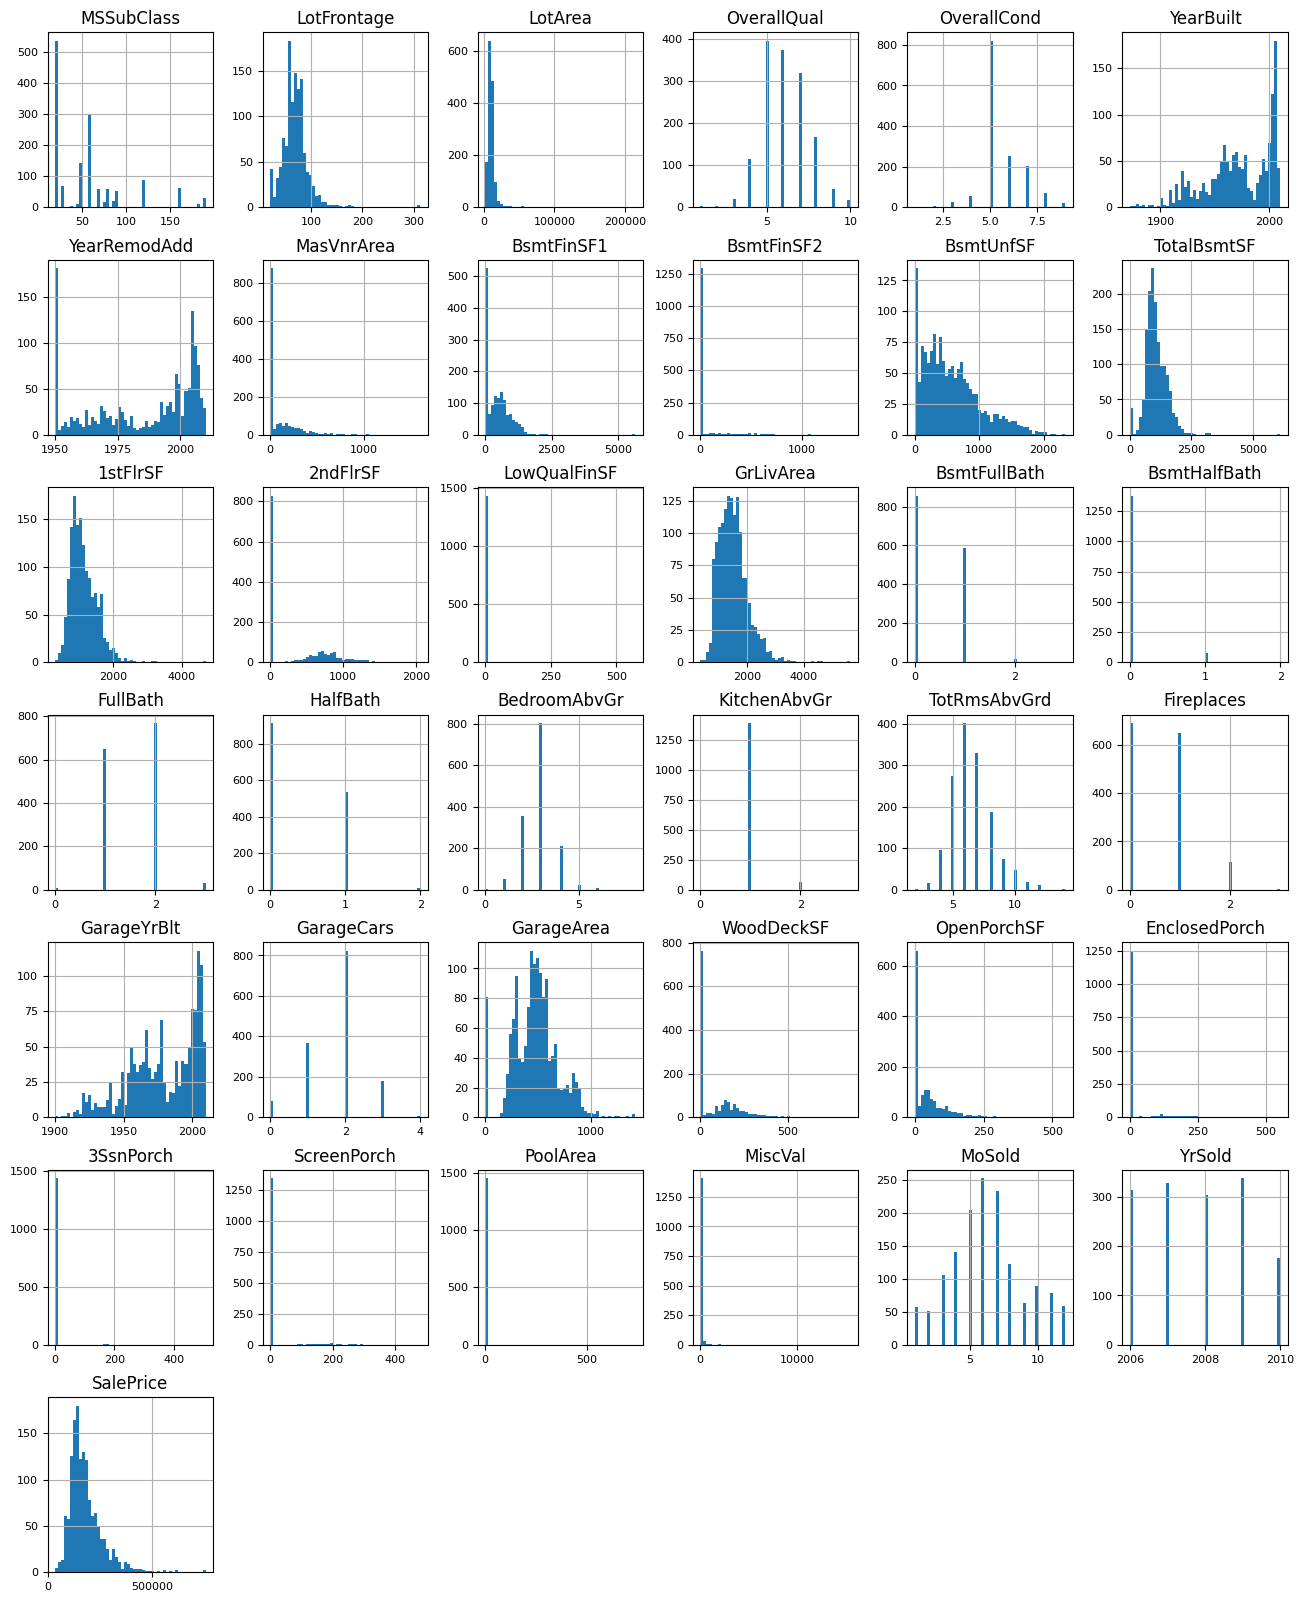

In [14]:
numeric_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); 

#### Cleaning numeric train dataset: "0" values in the dataset

In [15]:
numeric_df.count()

MSSubClass       1460
LotFrontage      1201
LotArea          1460
OverallQual      1460
OverallCond      1460
YearBuilt        1460
YearRemodAdd     1460
MasVnrArea       1452
BsmtFinSF1       1460
BsmtFinSF2       1460
BsmtUnfSF        1460
TotalBsmtSF      1460
1stFlrSF         1460
2ndFlrSF         1460
LowQualFinSF     1460
GrLivArea        1460
BsmtFullBath     1460
BsmtHalfBath     1460
FullBath         1460
HalfBath         1460
BedroomAbvGr     1460
KitchenAbvGr     1460
TotRmsAbvGrd     1460
Fireplaces       1460
GarageYrBlt      1379
GarageCars       1460
GarageArea       1460
WoodDeckSF       1460
OpenPorchSF      1460
EnclosedPorch    1460
3SsnPorch        1460
ScreenPorch      1460
PoolArea         1460
MiscVal          1460
MoSold           1460
YrSold           1460
SalePrice        1460
dtype: int64

In [16]:
numeric_df.shape[0]

1460

In [17]:
total_zero_numeric_values = (numeric_df == 0).sum()
percent_zero_numeric_values = (total_zero_numeric_values/numeric_df.shape[0]).sort_values(ascending=False)*100
missing_zero_numeric_values = pd.concat([total_zero_numeric_values, percent_zero_numeric_values], axis=1, keys=['Total_0', 'Percent_0'])
missing_zero_numeric_values.sort_values(by=['Percent_0'], axis=0, ascending=False).head(24)

,Total_0,Percent_0
PoolArea,1453,99.520548
3SsnPorch,1436,98.356164
LowQualFinSF,1434,98.219178
MiscVal,1408,96.438356
BsmtHalfBath,1378,94.383562
ScreenPorch,1344,92.054795
BsmtFinSF2,1293,88.561644
EnclosedPorch,1252,85.753425
HalfBath,913,62.534247
MasVnrArea,861,58.972603


Any of the above attributes that have more than 70% of missing values are to be deleted. Attributes that have more than 30% missing values and lower than 70% can be data engineered, afterwards we can assess the correlation matrix.

In [18]:
numeric_df.drop((missing_zero_numeric_values[missing_zero_numeric_values['Percent_0']>70]).index, axis=1, inplace=True)
missing_zero_numeric_values.drop((missing_zero_numeric_values[missing_zero_numeric_values['Percent_0']>70]).index, axis=0, inplace=True)

In [19]:
missing_zero_numeric_values[(missing_zero_numeric_values['Percent_0']>30)].index.tolist()

['MasVnrArea',
 'BsmtFinSF1',
 '2ndFlrSF',
 'BsmtFullBath',
 'HalfBath',
 'Fireplaces',
 'WoodDeckSF',
 'OpenPorchSF']

In [20]:
# select all attributes that are in the 30%-70% range
numeric_data_engineer = numeric_df[missing_zero_numeric_values[(missing_zero_numeric_values['Percent_0']>30)].index.tolist()].copy()

In [21]:
numeric_df.drop(missing_zero_numeric_values[(missing_zero_numeric_values['Percent_0']>30)].index.tolist(), axis=1, inplace=True)

In [22]:
value_of_interest = 0
for column in numeric_data_engineer.columns:
    new_column = column + str('_improved')
    numeric_data_engineer[new_column] = pd.Series(data=0, index=numeric_data_engineer.index)
    numeric_data_engineer.loc[numeric_data_engineer[column]>0, new_column] = 1
    numeric_data_engineer[column].replace(0, np.nan, inplace=True)

In [23]:
numeric_data_engineer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MasVnrArea             591 non-null    float64
 1   BsmtFinSF1             993 non-null    float64
 2   2ndFlrSF               631 non-null    float64
 3   BsmtFullBath           604 non-null    float64
 4   HalfBath               547 non-null    float64
 5   Fireplaces             770 non-null    float64
 6   WoodDeckSF             699 non-null    float64
 7   OpenPorchSF            804 non-null    float64
 8   MasVnrArea_improved    1460 non-null   int64  
 9   BsmtFinSF1_improved    1460 non-null   int64  
 10  2ndFlrSF_improved      1460 non-null   int64  
 11  BsmtFullBath_improved  1460 non-null   int64  
 12  HalfBath_improved      1460 non-null   int64  
 13  Fireplaces_improved    1460 non-null   int64  
 14  WoodDeckSF_improved    1460 non-null   int64  
 15  Open

In [24]:
numeric_data_engineer.iloc[:,8:].head(3)

,MasVnrArea_improved,BsmtFinSF1_improved,2ndFlrSF_improved,BsmtFullBath_improved,HalfBath_improved,Fireplaces_improved,WoodDeckSF_improved,OpenPorchSF_improved
0,1,1,1,1,1,0,0,1
1,0,1,0,0,0,1,1,0
2,1,1,1,1,1,1,0,1


In [25]:
numeric_train_data_final = pd.concat([numeric_df, numeric_data_engineer.iloc[:,8:]], axis=1)

In [26]:
numeric_train_data_final.corr()['SalePrice'].sort_values(ascending=False)[1:]

OverallQual              0.790982
GrLivArea                0.708624
GarageCars               0.640409
GarageArea               0.623431
TotalBsmtSF              0.613581
1stFlrSF                 0.605852
FullBath                 0.560664
TotRmsAbvGrd             0.533723
YearBuilt                0.522897
YearRemodAdd             0.507101
GarageYrBlt              0.486362
Fireplaces_improved      0.471908
OpenPorchSF_improved     0.412959
MasVnrArea_improved      0.360769
LotFrontage              0.351799
HalfBath_improved        0.299111
WoodDeckSF_improved      0.297662
LotArea                  0.263843
BsmtFullBath_improved    0.230846
BsmtUnfSF                0.214479
BedroomAbvGr             0.168213
2ndFlrSF_improved        0.137656
BsmtFinSF1_improved      0.133001
MoSold                   0.046432
YrSold                  -0.028923
OverallCond             -0.077856
MSSubClass              -0.084284
KitchenAbvGr            -0.135907
Name: SalePrice, dtype: float64

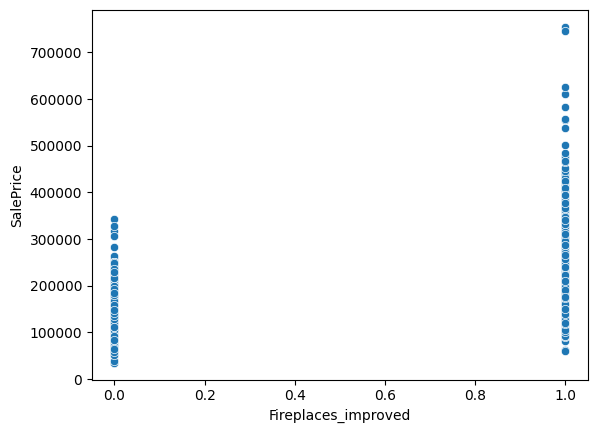

In [27]:
sns.scatterplot(data=numeric_train_data_final, x="Fireplaces_improved", y="SalePrice",)
plt.show()

We see that some columns have a quite similar profile. Moreover, some plots have very pronounced outliers

#### Improving data: centering and outliers

In [28]:
numeric_train_data_final['SalePrice'] = np.log(numeric_train_data_final['SalePrice'])

#### Deleting missing data

In [29]:
numeric_train_data_final.isna().sum().sort_values(ascending=False).head(3)

LotFrontage    259
GarageYrBlt     81
MSSubClass       0
dtype: int64

In [30]:
numeric_train_data_final.drop(['LotFrontage','GarageYrBlt'],axis=1, inplace=True)

## Object DataSet

#### Removing NaN columns

In [31]:
object_df.count()

MSZoning         1460
Street           1460
Alley              91
LotShape         1460
LandContour      1460
Utilities        1460
LotConfig        1460
LandSlope        1460
Neighborhood     1460
Condition1       1460
Condition2       1460
BldgType         1460
HouseStyle       1460
RoofStyle        1460
RoofMatl         1460
Exterior1st      1460
Exterior2nd      1460
MasVnrType       1452
ExterQual        1460
ExterCond        1460
Foundation       1460
BsmtQual         1423
BsmtCond         1423
BsmtExposure     1422
BsmtFinType1     1423
BsmtFinType2     1422
Heating          1460
HeatingQC        1460
CentralAir       1460
Electrical       1459
KitchenQual      1460
Functional       1460
FireplaceQu       770
GarageType       1379
GarageFinish     1379
GarageQual       1379
GarageCond       1379
PavedDrive       1460
PoolQC              7
Fence             281
MiscFeature        54
SaleType         1460
SaleCondition    1460
dtype: int64

In [32]:
total_missing_object_values = object_df.isna().sum()
percent_missing_object_values = (total_missing_object_values/object_df.shape[0]).sort_values(ascending=False)*100
missing_nan_object_values = pd.concat([total_missing_object_values, percent_missing_object_values], axis=1, keys=['Total_NaN', 'Percent_NaN'])
missing_nan_object_values.sort_values(by=['Percent_NaN'], axis=0, ascending=False).head(17)

,Total_NaN,Percent_NaN
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
GarageType,81,5.547945
GarageCond,81,5.547945
GarageQual,81,5.547945
GarageFinish,81,5.547945
BsmtFinType2,38,2.602740


All of the above missing values can be considered as the abscence of feature ! let's try this approach :-)

### Train and Validation dataset selection

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(numeric_train_data_final.drop(['SalePrice'], axis=1), numeric_train_data_final['SalePrice'], test_size=0.2, random_state=42)

In [34]:
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((1168, 26), (292, 26), (1168,), (292,))

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_model_performance(X, y, estimator, label):
    print(f'Perfomance of {label} model:')
    print('Mean absolute error:' , mean_absolute_error(y, estimator.predict(X)))
    print('Mean squared error:' , mean_squared_error(y, estimator.predict(X)))
    print('R2 score:' , r2_score(y, estimator.predict(X)))

#### Linear Regression Model

In [36]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression().fit(X_train, y_train)

In [37]:
print_model_performance(X_validation, y_validation, linear_reg, 'Linear Regressor' )

Perfomance of Linear Regressor model:
Mean absolute error: 0.10812593579745143
Mean squared error: 0.022359808641453767
R2 score: 0.8801811955993922


In [38]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

In [39]:
print_model_performance(X_validation, y_validation, forest_reg, 'Random Forest Regressor' )

Perfomance of Random Forest Regressor model:
Mean absolute error: 0.09701657022326994
Mean squared error: 0.022021449109898596
R2 score: 0.8819943521956132


In [40]:
from sklearn.svm import SVR

svr_reg = SVR().fit(X_train, y_train)

In [41]:
print_model_performance(X_validation, y_validation, svr_reg, 'Support Vector Machine Regressor' )

Perfomance of Support Vector Machine Regressor model:
Mean absolute error: 0.1596520444708299
Mean squared error: 0.05047409766818099
R2 score: 0.7295260378664965


In [42]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(random_state=42).fit(X_train, y_train)

In [43]:
print_model_performance(X_validation, y_validation, sgd_reg, 'Stochastic Gradient Descent Regressor')

Perfomance of Stochastic Gradient Descent Regressor model:
Mean absolute error: 1.149392431148149e+16
Mean squared error: 1.917079568249706e+32
R2 score: -1.0272994080220294e+33


In [44]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_reg = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)

In [45]:
print_model_performance(X_validation, y_validation, decision_tree_reg, 'Decision Tree Regressor')

Perfomance of Decision Tree Regressor model:
Mean absolute error: 0.14692368841242684
Mean squared error: 0.045782664812347405
R2 score: 0.7546658717857174


## Feature Scaling

In [46]:
X_pre_scaling = numeric_train_data_final.drop(['SalePrice'], axis=1)
y_pre_scaling = numeric_train_data_final['SalePrice']

In [47]:
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler # removed mean and scaling to unit variance

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("stf_scaler", StandardScaler()),
])

X_post_scaling = numerical_pipeline.fit_transform(X_pre_scaling)

In [48]:
X_train_scaled, X_validation_scaled, y_train_scaled, y_validation_scaled = train_test_split(X_post_scaling, y_pre_scaling, test_size=0.2, random_state=42)

In [49]:
linear_reg_scaled = LinearRegression().fit(X_train_scaled, y_train_scaled)

In [50]:
print_model_performance(X_validation_scaled, y_validation_scaled, linear_reg_scaled, 'Linear Regressor Scaled')

Perfomance of Linear Regressor Scaled model:
Mean absolute error: 0.10812593579744909
Mean squared error: 0.022359808641453455
R2 score: 0.8801811955993939


In [51]:
sgd_reg_scaled = SGDRegressor(random_state=42).fit(X_train_scaled, y_train_scaled)

In [52]:
print_model_performance(X_validation_scaled, y_validation_scaled, sgd_reg_scaled, 'Stochastic Gradient Descent Regressor Scaled')

Perfomance of Stochastic Gradient Descent Regressor Scaled model:
Mean absolute error: 0.11278956441923553
Mean squared error: 0.022752029486972903
R2 score: 0.8780794140714425


In [53]:
svr_reg_scaled = SVR().fit(X_train_scaled, y_train_scaled)

In [54]:
print_model_performance(X_validation_scaled, y_validation_scaled, svr_reg_scaled, 'Stochastic Gradient Descent Regressor Scaled')

Perfomance of Stochastic Gradient Descent Regressor Scaled model:
Mean absolute error: 0.09694993480084506
Mean squared error: 0.020966453876953547
R2 score: 0.8876477220203202


In [55]:
forest_reg_scaled = RandomForestRegressor().fit(X_train_scaled, y_train_scaled)

In [56]:
print_model_performance(X_validation_scaled, y_validation_scaled, forest_reg_scaled, 'Random Forest Regressor Scaled')

Perfomance of Random Forest Regressor Scaled model:
Mean absolute error: 0.09720199978007536
Mean squared error: 0.022192344727897606
R2 score: 0.8810785792140867


In [57]:
decision_tree_reg_scaled = DecisionTreeRegressor(random_state=42).fit(X_train_scaled, y_train_scaled)

In [58]:
print_model_performance(X_validation_scaled, y_validation_scaled, decision_tree_reg_scaled, 'Decision Tree Regressor Scaled')

Perfomance of Decision Tree Regressor Scaled model:
Mean absolute error: 0.147230483877562
Mean squared error: 0.04612022423481813
R2 score: 0.7528570027089214


#### Voting Regresssor (ensemble method)

In [59]:
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(
    estimators=[('linear', linear_reg), ('forest', forest_reg), ('SGD',sgd_reg), ('decision_tree', decision_tree_reg)],
)
voting_reg.fit(X_train_scaled, y_train_scaled)

print_model_performance(X_validation_scaled, y_validation_scaled, voting_reg, 'Voting Regressor Scaled')

Perfomance of Voting Regressor Scaled model:
Mean absolute error: 0.1027497237621144
Mean squared error: 0.021741294378086626
R2 score: 0.8834956085592589


#### Bagging Regressor (ensemble method)

In [60]:
from sklearn.ensemble import BaggingRegressor

bag_reg = BaggingRegressor(
    DecisionTreeRegressor(), n_estimators=1000, 
    max_samples=300, bootstrap=True, n_jobs=-1, oob_score=True)
bag_reg.fit(X_train_scaled, y_train_scaled)

BaggingRegressor(estimator=DecisionTreeRegressor(), max_samples=300,
                 n_estimators=1000, n_jobs=-1, oob_score=True)

In [61]:
print_model_performance(X_validation_scaled, y_validation_scaled, bag_reg, 'Bagging Regressor Scaled')

Perfomance of Bagging Regressor Scaled model:
Mean absolute error: 0.1028599810177428
Mean squared error: 0.023919204908794105
R2 score: 0.8718249077914058


#### AdaBoosting Regressor (ensemble method)

In [62]:
from sklearn.ensemble import AdaBoostRegressor

adaboost_reg = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=200), n_estimators=200,
    learning_rate=0.1, random_state=42)
adaboost_reg.fit(X_train_scaled, y_train_scaled)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=200),
                  learning_rate=0.1, n_estimators=200, random_state=42)

In [63]:
print_model_performance(X_validation_scaled, y_validation_scaled, adaboost_reg, 'AdaBoost Regressor Scaled')

Perfomance of AdaBoost Regressor Scaled model:
Mean absolute error: 0.09617674196852302
Mean squared error: 0.02287344117739478
R2 score: 0.877428809058677


#### Gradient Boosting Regressor (ensemble method)

In [64]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boost_reg = GradientBoostingRegressor(max_depth=2, n_estimators=250, learning_rate=0.03)
gradient_boost_reg.fit(X_train_scaled, y_train_scaled)

GradientBoostingRegressor(learning_rate=0.03, max_depth=2, n_estimators=250)

In [65]:
print_model_performance(X_validation_scaled, y_validation_scaled, gradient_boost_reg, 'Gradient Boost Regressor Scaled')

Perfomance of Gradient Boost Regressor Scaled model:
Mean absolute error: 0.10042769280725253
Mean squared error: 0.021332040298930287
R2 score: 0.8856886655414047


#### Stacking (ensemble method)
Stacking is an ensemble machine learning algorithm that learns how to best combine the predictions from multiple well-performing machine learning models.
* Level-0 Models (Base-Models): Models fit on the training data and whose predictions are compiled.
* Level-1 Model (Meta-Model): Model that learns how to best combine the predictions of the base models. <br>

The meta-model is trained on the predictions made by base models on out-of-sample data. That is, data not used to train the base models is fed to the base models, predictions are made, and these predictions, along with the expected outputs, provide the input and output pairs of the training dataset used to fit the meta-model. <br>
The outputs from the base models used as input to the meta-model may be real value in the case of regression, and probability values, probability like values, or class labels in the case of classification.

In [66]:
from sklearn.ensemble import StackingRegressor

stacking_reg = StackingRegressor(
    estimators= [('linear', linear_reg), ('forest', forest_reg), ('SGD',sgd_reg), ('decision_tree', decision_tree_reg)],
    final_estimator=RandomForestRegressor(random_state=42))
stacking_reg.fit(X_train_scaled, y_train_scaled)
print_model_performance(X_validation_scaled, y_validation_scaled, stacking_reg, 'Stacking Regressor Scaled')

Perfomance of Stacking Regressor Scaled model:
Mean absolute error: 0.10549332671397942
Mean squared error: 0.023303344688463214
R2 score: 0.8751250986141992


In [67]:
stacking_reg = StackingRegressor(
    estimators= [('linear', linear_reg), ('forest', forest_reg), ('SGD',sgd_reg), ('decision_tree', decision_tree_reg)],
    final_estimator=LinearRegression())
stacking_reg.fit(X_train_scaled, y_train_scaled)
print_model_performance(X_validation_scaled, y_validation_scaled, stacking_reg, 'Stacking Regressor Scaled')

Perfomance of Stacking Regressor Scaled model:
Mean absolute error: 0.09797665203924953
Mean squared error: 0.019626553553957492
R2 score: 0.8948278038041926


In [68]:
stacking_reg = StackingRegressor(
    estimators= [('linear', linear_reg), ('forest', forest_reg), ('SGD',sgd_reg), ('decision_tree', decision_tree_reg)],
    final_estimator=DecisionTreeRegressor())
stacking_reg.fit(X_train_scaled, y_train_scaled)
print_model_performance(X_validation_scaled, y_validation_scaled, stacking_reg, 'Stacking Regressor Scaled')

Perfomance of Stacking Regressor Scaled model:
Mean absolute error: 0.13661809141267847
Mean squared error: 0.03747162323954966
R2 score: 0.7992019892697545


#### Blending (ensemble method)
* **Blending**: Stacking-type ensemble where the meta-model is trained on predictions made on a holdout dataset.
* **Stacking**: Stacking-type ensemble where the meta-model is trained on out-of-fold predictions made during k-fold cross-validation.


In [69]:
estimator_list = [linear_reg_scaled, sgd_reg_scaled, svr_reg_scaled, forest_reg_scaled, decision_tree_reg_scaled]

In [70]:
X_validation_blend_predictions = np.empty((len(X_validation_scaled), len(estimator_list)), dtype=np.float32)

In [71]:
for index, estimator in enumerate(estimator_list):
    X_validation_blend_predictions[:, index] = estimator.predict(X_validation_scaled)
    # estimator.predict(X_validation_scaled)
    # print(index, estimator)

In [72]:
X_validation_blend_predictions

array([[11.930394 , 11.917921 , 11.813291 , 11.842552 , 11.845102 ],
       [12.608471 , 12.600365 , 12.684993 , 12.670398 , 12.691581 ],
       [11.655365 , 11.626841 , 11.688654 , 11.6627445, 11.695247 ],
       ...,
       [12.300677 , 12.321426 , 12.194243 , 12.136576 , 12.122691 ],
       [11.616081 , 11.562338 , 11.678312 , 11.793017 , 12.000892 ],
       [11.702578 , 11.655367 , 11.759371 , 11.651502 , 11.661777 ]],
      dtype=float32)

In [73]:
rnd_forest_blender = RandomForestRegressor(oob_score=True, random_state=42)
rnd_forest_blender.fit(X_validation_blend_predictions, y_validation_scaled)

RandomForestRegressor(oob_score=True, random_state=42)

In [74]:
rnd_forest_blender.oob_score_

0.882794475981022